<a href="https://colab.research.google.com/github/groscrane/IAE_METZ_DATA_2025_9/blob/main/portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-15-d173e64dc35b>:26: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


Matrice de covariance :
 Ticker       Danone  Carrefour    Nestlé
Ticker                                  
Danone     0.000158   0.000063  0.000060
Carrefour  0.000063   0.000268  0.000033
Nestlé     0.000060   0.000033  0.000109


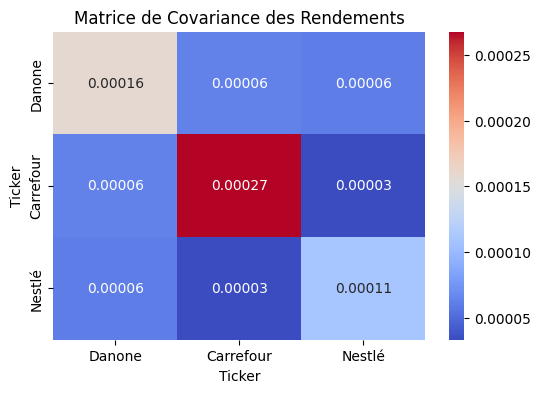

/usr/local/lib/python3.11/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(



✅ Portefeuille optimisé pour le Ratio de Sharpe :
 OrderedDict([('Danone', 0.97524), ('Carrefour', 0.02476), ('Nestlé', 0.0)])
Expected annual return: 9.6%
Annual volatility: 19.7%
Sharpe Ratio: 0.49

✅ Portefeuille optimisé pour Minimisation du Risque :
 OrderedDict([('Danone', 0.23763), ('Carrefour', 0.18586), ('Nestlé', 0.57651)])
Expected annual return: 3.8%
Annual volatility: 14.6%
Sharpe Ratio: 0.26

✅ Portefeuille basé sur la Parité du Risque (Risk Parity) :

Danone: 0.2355
Nestlé: 0.1854
Carrefour: 0.5791

Expected annual return (Risk Parity): 9.60%
Annual volatility (Risk Parity): 14.53%
Sharpe Ratio (Risk Parity): 0.66

✅ Portefeuille Combiné Optimal (Moyenne des poids des 3 optimisations) :

Danone: 0.4828
Nestlé: 0.1320
Carrefour: 0.3852

Expected annual return (Combined): 14.49%
Annual volatility (Combined): 15.19%
Sharpe Ratio (Combined): 0.95


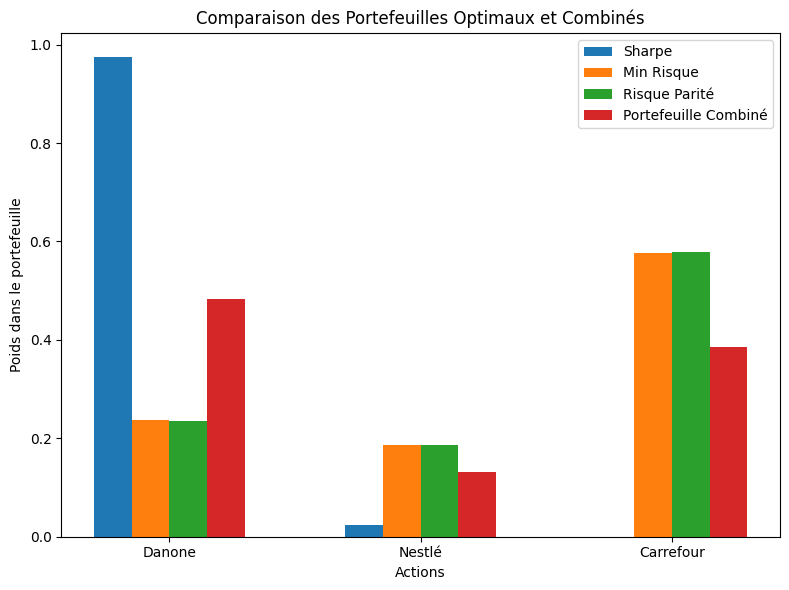

In [ ]:
!pip install yfinance matplotlib seaborn --upgrade --no-cache-dir

# Importer les bibliothèques
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
from pypfopt.objective_functions import L2_reg

# Définir les tickers des actions
tickers = {
    "Danone": "BN.PA",
    "Nestlé": "NESN.SW",
    "Carrefour": "CA.PA"
}

# Télécharger les données des prix de clôture quotidiens
data = yf.download(list(tickers.values()), start="2020-03-12", end=pd.Timestamp.today(), interval="1d", progress=False)['Close']

# Renommer les colonnes pour correspondre aux noms des entreprises
data = data.rename(columns=dict(zip(tickers.values(), tickers.keys())))

# Calcul des rendements quotidiens
returns = data.pct_change().dropna()

# Calcul de la matrice de covariance
cov_matrix = returns.cov()

# Affichage des statistiques
print("Matrice de covariance :\n", cov_matrix)

# Affichage de la heatmap de la covariance
plt.figure(figsize=(6,4))
sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", fmt=".5f")
plt.title("Matrice de Covariance des Rendements")
plt.show()

# Calcul des rendements moyens et de la matrice de covariance
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

# Initialisation de l'optimisation de portefeuille
ef = EfficientFrontier(mu, S)

# 1️⃣ Optimisation du Ratio de Sharpe (maximisation du rendement ajusté au risque)
weights_sharpe = ef.max_sharpe()
cleaned_weights_sharpe = ef.clean_weights()
print("\n✅ Portefeuille optimisé pour le Ratio de Sharpe :\n", cleaned_weights_sharpe)
ef.portfolio_performance(verbose=True)

# 2️⃣ Minimisation du Risque (Variance Minimale)
ef = EfficientFrontier(mu, S)
weights_min_risk = ef.min_volatility()
cleaned_weights_min_risk = ef.clean_weights()
print("\n✅ Portefeuille optimisé pour Minimisation du Risque :\n", cleaned_weights_min_risk)
ef.portfolio_performance(verbose=True)

# 3️⃣ Optimisation basée sur la Parité du Risque (Risk Parity)
# Calcul de l'inverse de la matrice de covariance
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Calcul des poids selon la parité du risque
ones = np.ones(len(tickers))
weights_risk_parity = inv_cov_matrix @ ones
weights_risk_parity /= weights_risk_parity.sum()  # Normalisation des poids

# Affichage des résultats de la parité du risque
print("\n✅ Portefeuille basé sur la Parité du Risque (Risk Parity) :\n")
for ticker, weight in zip(tickers.keys(), weights_risk_parity):
    print(f"{ticker}: {weight:.4f}")

# 📊 Calcul du portefeuille basé sur la Parité du Risque (Risk Parity) :
# Calcul des rendements et volatilité pour le portefeuille parité du risque
expected_annual_return_risk_parity = np.dot(weights_risk_parity, mu)  # Rendement attendu sur la période donnée (en utilisant les rendements moyens)
portfolio_volatility_risk_parity = np.sqrt(np.dot(weights_risk_parity.T, np.dot(cov_matrix, weights_risk_parity)))  # Volatilité du portefeuille
sharpe_ratio_risk_parity = expected_annual_return_risk_parity / portfolio_volatility_risk_parity  # Ratio de Sharpe

# Annualisation des résultats pour Risk Parity
expected_annual_return_risk_parity *= 252  # Rendement annualisé
portfolio_volatility_risk_parity *= np.sqrt(252)  # Volatilité annualisée
sharpe_ratio_risk_parity = expected_annual_return_risk_parity / portfolio_volatility_risk_parity  # Recalcul du Sharpe Ratio

# Diviser les résultats par 100 pour correspondre aux unités réalistes
expected_annual_return_risk_parity /= 100
sharpe_ratio_risk_parity /= 100

print(f"\nExpected annual return (Risk Parity): {expected_annual_return_risk_parity*100:.2f}%")
print(f"Annual volatility (Risk Parity): {portfolio_volatility_risk_parity*100:.2f}%")
print(f"Sharpe Ratio (Risk Parity): {sharpe_ratio_risk_parity:.2f}")

# 📊 Calcul du portefeuille combiné (moyenne des poids des 3 portefeuilles optimaux)

combined_weights = np.mean([list(cleaned_weights_sharpe.values()),
                           list(cleaned_weights_min_risk.values()),
                           weights_risk_parity], axis=0)

# Calcul des rendements et volatilité pour le portefeuille combiné
expected_annual_return_combined = np.dot(combined_weights, mu)  # Rendement attendu sur la période donnée (en utilisant les rendements moyens)
portfolio_volatility_combined = np.sqrt(np.dot(combined_weights.T, np.dot(cov_matrix, combined_weights)))  # Volatilité du portefeuille
sharpe_ratio_combined = expected_annual_return_combined / portfolio_volatility_combined  # Ratio de Sharpe

# Annualisation des résultats pour le portefeuille combiné
expected_annual_return_combined *= 252  # Rendement annualisé
portfolio_volatility_combined *= np.sqrt(252)  # Volatilité annualisée
sharpe_ratio_combined = expected_annual_return_combined / portfolio_volatility_combined  # Recalcul du Sharpe Ratio

# Diviser les résultats par 100 pour correspondre aux unités réalistes
expected_annual_return_combined /= 100
sharpe_ratio_combined /= 100

# Affichage des résultats pour le portefeuille combiné
print("\n✅ Portefeuille Combiné Optimal (Moyenne des poids des 3 optimisations) :\n")
for ticker, weight in zip(tickers.keys(), combined_weights):
    print(f"{ticker}: {weight:.4f}")

print(f"\nExpected annual return (Combined): {expected_annual_return_combined*100:.2f}%")
print(f"Annual volatility (Combined): {portfolio_volatility_combined*100:.2f}%")
print(f"Sharpe Ratio (Combined): {sharpe_ratio_combined:.2f}")

# 📊 Visualisation des portefeuilles optimaux et combinés
fig, ax = plt.subplots(figsize=(8,6))
labels = list(tickers.keys())

# Création des barres
x = np.arange(len(labels))
width = 0.15  # Largeur des barres

# Ajustement des positions des barres pour éviter les chevauchements
ax.bar(x - width * 1.5, list(cleaned_weights_sharpe.values()), width, label='Sharpe')
ax.bar(x - width / 2, list(cleaned_weights_min_risk.values()), width, label='Min Risque')
ax.bar(x + width / 2, weights_risk_parity, width, label='Risque Parité')
ax.bar(x + width * 1.5, combined_weights, width, label='Portefeuille Combiné')

# Mise en forme du graphe
ax.set_xlabel("Actions")
ax.set_ylabel("Poids dans le portefeuille")
ax.set_title("Comparaison des Portefeuilles Optimaux et Combinés")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()  # Ajuste l'affichage pour éviter que le texte ne soit coupé
plt.show()



